### XGBoost-based prediction of residual properties of aged FRP composites
Copyright (C) 2025 João Paulo D. de S. Pereira
License: GPL-3.0 (https://www.gnu.org/licenses/gpl-3.0.en.html)

In [365]:
# Library imports
from category_encoders.target_encoder import TargetEncoder
from contextlib import suppress
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display
from sklearn.metrics import r2_score, PredictionErrorDisplay
from sklearn.model_selection import train_test_split, learning_curve, KFold  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import PartialDependenceDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import xgboost as xgb
from xgboost import plot_importance, XGBRegressor
import time
from datetime import datetime
import seaborn as sns

In [366]:
# Record and display execution start time
start_time = time.time()
now = datetime.now()
print(now.strftime("%d/%m/%Y %H:%M:%S"))

15/04/2025 10:57:11


In [367]:
def load_dataset(
        file_name='training-dataset.csv',
        target='Residual tensile modulus (GPa)',
        min_target_counts=1,
        cols_to_drop=[]
        ):
    """Read and process a .CSV file into a filtered pandas DataFrame.

    Args:
        file_name (string): Name of training dataset file.
        target (string): Column name of the target property.
        min_target_counts (int | float): Minimum count threshold for target
            values. Rows with values appearing fewer times are dropped.
        cols_to_drop (list): List with unimportant features to be removed from
            the analysis.
    
    Returns:
        pandas.DataFrame: Filtered dataset with only relevant columns. Rows
            with values appearing fewer times are dropped.
    
    Notes:
        The .CSV file path is hardcoded in this version and not
            user-configurable. All files used herein shall be in the same folder
        XGBoost is sparsity-aware. No need to drop missing values.
    """

    # Definition of dataset path
    file_path=str(os.getcwd()) + '\\' + file_name
    
    # Read .CSV as pandas dataframe
    df = pd.read_csv(file_path, delimiter=';')

    # Drop columns that are not important for the analysis
    df = df.drop(columns=cols_to_drop)

    # Remove unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Filters target property values that appear less than min_target_count times
    value_counts = df[target].value_counts()
    valid_values = value_counts[value_counts > min_target_counts - 1].index
    df = df[df[target].isin(valid_values)]

    return df

In [368]:
def get_abs_error(y_test, y_pred):  
    """Calculate the maximum signed absolute error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed absolute error (y_pred - y_test), rounded to
                3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.    
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_abs_error(y_test, y_pred)
        -0.4
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i]))
        
    abs_error = max(a, key=abs)

    return round(abs_error, 3)

In [369]:
def get_rel_error(y_test, y_pred):
    """Calculate the maximum signed relative error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed relative error ((y_pred - y_test) / y_test),
                rounded to 3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rel_error(y_test, y_pred)
        -0.167
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i])/y_test[i])
        
    rel_error = max(a, key=abs)

    return round(rel_error, 3)

In [370]:
def get_mae(y_test, y_pred):
    """Calculate the mean absolute error (MAE) between predicted and actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: MAE (Σ(|y_pred - y_test|) / len(y_test)), rounded to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_mae(y_test, y_pred)
        0.233
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + abs(y_pred[i] - y_test[i])
        
    mae = a / len(y_test)

    return round(mae, 3)

In [371]:
def get_rmse(y_test, y_pred):
    """Calculate the root mean squared error (RMSE) between predicted and
        actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: RMSE ((Σ(|y_pred - y_test|)² / len(y_test))^0.5), rounded
                to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rmse(y_test, y_pred)
        0.265
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + (y_pred[i] - y_test[i]) ** 2
        
    rmse = np.sqrt(a / len(y_test))

    return round(rmse, 3)

In [372]:
def get_r2(y_test, y_pred):
    """Calculate the coefficient of determination (or R² score) of predicted
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: R² score (1 - RSS/TSS), rounded to 3 decimals.
        
        Note:
            RSS: Residual sum of squares (Σ(y_pred - y_test)²).
            TSS: Total sum of squares (Σ(mean - y_test)²), i.e., variability of
                the actual data.
            An R² score equal to 1 indicates a perfect fit between predicted and
                actual values. An R² equal to 0 means the prediction is no better
                than the mean. A negative R² indicates the prediction is worse
                than the mean.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_r2(y_test, y_pred)
        0.978
    """
    
    y_test = y_test.tolist()
    mean = sum(y_test) / len(y_test)
    rss = 0  # Residual sum of squares
    tss = 0  # Total sum of squares
    for i in range(len(y_test)):
        rss = rss + (y_pred[i] - y_test[i]) ** 2
        tss = tss + (mean - y_test[i]) ** 2

    r2 = 1 - rss / tss

    return round(r2, 3)

In [373]:
class Predictor:
    """Train XGBoost model with Bayesian optimization and predict the long-term
        property retention of aged FRP composites.
    """

    def __init__(
        self,
        model_params: dict = {
            'encoder': TargetEncoder(),
            'clf': {
                'booster'       :'gbtree',
                'base_score'    :1.0,
                'eval_metric'   :'rmse'
                },
            'bayes_cv': {
                'search_space': {
                    'clf__max_depth'            :Integer(3, 7),
                    'clf__n_estimators'         :Integer(200, 500),
                    'clf__learning_rate'        :Real(0.01, 0.1,
                        prior='log-uniform'),
                    'clf__subsample'            :Real(0.6, 1.0),
                    'clf__colsample_bytree'     :Real(0.6, 1.0),
                    'clf__reg_alpha'            :Real(0.5, 1.0),
                    'clf__reg_lambda'           :Real(0.5, 1.0),
                    'clf__gamma'                :Real(0.0, 0.05),
                    'clf__min_child_weight'     :Integer(2, 5)
                    },
                'n_iter'        :60,
                'scoring'       :'neg_root_mean_squared_error',
                'n_jobs'        :6
                }
            },
            target='Residual tensile modulus (GPa)'
        ):
        """Args:
            model_params (dict, optional): Dictionary containing all model parameters.
                Structure:
                - encoder: Categorical variable encoder.
                - clf: Estimator parameters.
                    - booster (str): Booster type.
                    - base_score (float): Initial prediction value.
                    - eval_metric  (Union[str, List[str], Callable, NoneType]):
                        Metric for training result monitoring.
                - bayes_cv: Bayesian optimization parameters (hyperparameter tuning).
                    - search_space: Hyperparameter ranges for optimization.
                    - cv: Number of cross-validation folds.
                    - n_iter: Number of hyperparameter combinations to test.
                    - n_jobs: Number of CPU cores to be used in parallel.
            target (str, optional): Target property name.

        Attributes:
            - model_params (dict): Stored model parameters.
            - target (str): Stored target property.
            - cv_strategy (KFold): Cross-validation configuration. Shuffling is
                enabled to ensure representative samples in each split.
            - dataset (dict): Will store dataset information.
            - n_runs (int): Will store number of models to be trained.
            - trained_models (list): Will store models and metrics dicts after training.
            - overall_stats (dict): Will store statiscally treated errors and R² score.
            - best_model (XGBRegressor): Will store top-performing model.
        """

        self.model_params   = model_params
        self.target         = target
        self.cv_strategy    = KFold(n_splits=5, shuffle=True)
        self.dataset        = {
            'dataset'           :0,
            'X'                 :0,
            'y'                 :0
        }
        self.n_runs         = 0
        self.trained_models = []
        self.overall_stats  = {
            'abs_error_mean'    :0,
            'abs_error_std'     :0,
            'rel_error_mean'    :0,
            'rel_error_std'     :0,
            'mae_mean'          :0,
            'mae_std'           :0,
            'rmse_mean'         :0,
            'rmse_std'          :0,
            'r2_mean'           :0,
            'r2_std'            :0
        }
        self.best_model     = None
        
    def create_model(self, file_name='training-dataset.csv', cols_to_drop=[], log_transf=[]):
        """Sets up a Bayesian-optimized XGBoost regression pipeline including:
            - Optional log-transformation of specified features
            - Data preprocessing (encoding)
            - XGBoost regressor with Bayesian hyperparameter optimization
        
        Args:
            file_name (str, optional): Name of training dataset file.
            cols_to_drop (list): List with unimportant features to be removed from
            the analysis.
            log_transf (list, optional): List of feature names to apply log10
                transformation. Defaults to empty list.
                
        Returns:
            skopt.BayesSearchCV: Configured Bayesian optimization search object with:
                - Preprocessing pipeline (encoder + XGBoost)
                - Parameter search space
                - Cross-validation strategy
                - Evaluation metrics
                
        Notes:
            - Pipeline includes automatic encoding of categorical variables
            - Uses XGBoost's 'reg:squarederror' objective by default
        """
        
        # Load dataset
        df = load_dataset(file_name=file_name, target=self.target, cols_to_drop=cols_to_drop)

        # Log-transform features with outlier values
        for i in range(len(log_transf)):
            df[log_transf[i]] = np.log10(df[log_transf[i]])
        
        # Separate independent variables from target
        X = df.drop(columns=self.target)
        y = df[self.target]
        
        # Store dataset and splits
        self.dataset['dataset'] = df
        self.dataset['X'] = X
        self.dataset['y'] = y

        # Configure training pipeline and hyperparameter tuning
        estimators = [
            ('encoder', self.model_params['encoder']),
            ('clf', XGBRegressor(
                booster                 =self.model_params['clf']['booster'],
                base_score              =self.model_params['clf']['base_score'],
                eval_metric             =self.model_params['clf']['eval_metric'],
                objective               ='reg:squarederror'
                )
            )
        ]
                
        opt = BayesSearchCV(
            Pipeline(steps=estimators),
            self.model_params['bayes_cv']['search_space'],
            cv                  = self.cv_strategy,
            n_iter              = self.model_params['bayes_cv']['n_iter'],
            scoring             = self.model_params['bayes_cv']['scoring'],
            error_score         = 'raise',
            return_train_score  = True,
            n_jobs              = self.model_params['bayes_cv']['n_jobs'],
            n_points            = 1,
            verbose             = False
            )
        
        return opt

    def train(self, file_name='training-dataset.csv', target='Residual tensile modulus (GPa)',
            cols_to_drop=[], n_runs=10, q=5, test_size=0.2, best_metric='r2', log_transf=[]):
        """Performs training pipeline for n_runs models including:
            - Dataset preparation with optional log transformations
            - Multiple train-test splits with target-stratified sampling
            - Bayesian-optimized XGBoost training for each split
            - Performance evaluation (abs. error, rel. error, MAE, RMSE and R²)

        Args:
            file_name (str, optional): Name of training dataset file.
            target (str, optional): Target property name.
            cols_to_drop (list): List with unimportant features to be removed from
            the analysis.
            n_runs (int, optional): Number of independent training runs with
                different data splits. Defaults to 10.
            q (int, optional): Number of quantiles for stratified sampling of
                continuous target variable. Defaults to 5.
            test_size (float, optional): Proportion of dataset to use for
                validation. Defaults to 0.2.
            best_metric (str, optional): Metric used to select best model.
                Options: 'r2' (R-squared), 'mae' (Mean Absolute Error), 'rmse'
                (Root Mean Squared Error). Defaults to 'r2'.
            log_transf (list, optional): List of feature names to apply log10
                transformation. Defaults to empty list.

        Returns:
            None: Updates object attributes with trained models and statistics.

        Attributes Modified:
            trained_models (list): Stores dictionaries containing:
                - Trained model objects
                - Training/test data
                - Prediction results
                - Evaluation metrics
                - Feature importance
            overall_stats (dict): Aggregated statistics across all runs:
                - Absolute/relative errors
                - Mean ± std of MAE, RMSE, R²
            best_model (dict): Information for best-performing model based on
                best_metric

        Notes:
            - Uses quantile-based stratification to maintain target distribution
            - Implements Bayesian optimization for hyperparameter tuning
            - Stores model information for post-analysis
        """

        # Create model
        model = self.create_model(file_name=file_name, log_transf=log_transf,
            cols_to_drop=cols_to_drop)

        # Load dataset
        df = self.dataset['dataset']
        X = df.drop(columns=self.target)
        y = df[self.target]
        
        # Restart attributes
        self.n_runs = n_runs
        self.trained_models = []

        # Bin the continuous target into categories for stratification
        bins = pd.qcut(y, q=q, duplicates='drop')

        loop_start = time.time()
        for i in range(n_runs):

            # Split data in training and test groups
            X_train, X_test, y_train, y_test = train_test_split(X, y,
                test_size=test_size, stratify=bins
                )
        
            # Train model
            print('Starting fit #', i+1, sep='')
            fit_start = time.time()
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S\n"))
            model.fit(X_train, y_train)
            fit_finish = time.time()
            print('Fit #', i+1, ' is finished! (%s s)\n'
                % round((fit_finish - fit_start), 1), sep='')
            if i == n_runs - 1:
                print('Total training duration: %s s\n'
                    % round((fit_finish - loop_start), 1), sep='')
            y_pred = model.predict(X_test)
            model_info = {
                'id': i,
                'model': model.best_estimator_,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_pred': y_pred,
                'y_test': y_test,
                'abs_error': get_abs_error(y_test, y_pred),
                'rel_error': get_rel_error(y_test, y_pred),
                'mae': get_mae(y_test, y_pred),
                'rmse': get_rmse(y_test, y_pred),
                'r2': get_r2(y_test, y_pred),
                'best_cv_score': model.best_score_,
                'best_params': model.best_params_,
                'importance_plot': model.best_estimator_.steps[1][1],
                'importance_score': model.best_estimator_.steps[1][1].
                    get_booster().get_score(importance_type='weight')
                }
            self.trained_models.append(model_info)
        
        # Extract metrics, calculate and store statistics
        abs_error = [self.trained_models[i]['abs_error']
            for i in range(len(self.trained_models))]
        abs_error_mean = np.mean(abs_error)
        abs_error_std = np.std(abs_error)
        self.overall_stats['abs_error_mean'] = abs_error_mean
        self.overall_stats['abs_error_std'] = abs_error_std
        print(f"Abs. error: {abs_error_mean:.2f} ± {abs_error_std:.2f}")

        rel_error = [self.trained_models[i]['rel_error']
            for i in range(len(self.trained_models))]
        rel_error_mean = np.mean(rel_error)
        rel_error_std = np.std(rel_error)
        self.overall_stats['rel_error_mean'] = rel_error_mean
        self.overall_stats['rel_error_std'] = rel_error_std
        print(f"Rel. error: {100 * rel_error_mean:.1f} ± {100 * rel_error_std:.1f}%")

        mae = [self.trained_models[i]['mae']
            for i in range(len(self.trained_models))]
        mae_mean = np.mean(mae)
        mae_std = np.std(mae)
        self.overall_stats['mae_mean'] = mae_mean
        self.overall_stats['mae_std'] = mae_std
        print(f"MAE: {mae_mean:.3f} ± {mae_std:.3f}")

        rmse = [self.trained_models[i]['rmse']
            for i in range(len(self.trained_models))]
        rmse_mean = np.mean(rmse)
        rmse_std = np.std(rmse)
        self.overall_stats['rmse_mean'] = rmse_mean
        self.overall_stats['rmse_std'] = rmse_std
        print(f"RMSE: {rmse_mean:.3f} ± {rmse_std:.3f}")

        r2 = [self.trained_models[i]['r2']
            for i in range(len(self.trained_models))]
        r2_mean = np.mean(r2)
        r2_std = np.std(r2)
        self.overall_stats['r2_mean'] = r2_mean
        self.overall_stats['r2_std'] = r2_std
        print(f"R²: {r2_mean:.2f} ± {r2_std:.2f}\n")
    
        # Store the best model
        best_model = max(self.trained_models, key=lambda x: x['r2'])
        self.best_model = best_model
    
    def plot_learning_curves(self, q=5, test_size=0.2, metrics=[1,1,1],
        ylim_1=(-1.1, -0.4), ylim_2=(0, 7), ylim_3=(0.4, 1.1)):
        """Plots MAE, RMSE, and R² learning curves to assess underfitting/overfitting
        
        Args:
            q (int, optional): Number of quantiles for stratification.
                Defaults to 5.
            test_size (float, optional): Proportion of dataset to use for
                validation. Defaults to 0.2.
            metrics (list, optional): Which metrics to plot [MAE, RMSE, R²]. 
                1=plot, 0=skip. Defaults to [1,1,1] (all metrics).

        Returns:
            None: Displays matplotlib figures with learning curves and prints
                mean ± std across CV folds.
                
        Notes:
            - Uses stratified sampling to maintain target distribution
        """
        
        # Separate independent variables from target
        X = self.dataset['X']
        y = self.dataset['y']

        # Define marker styles for different models
        markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', 'd']  # Add more if needed
        fill = ['full', 'none']  # Alternate filled/unfilled

        if metrics[0] == 1:
            plt.figure(figsize=(10, 6))
            
            train_score_total = []
            test_score_total = []

            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(  
                    self.trained_models[i]['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, scoring='neg_root_mean_squared_error', return_times=True
                )

                # Converting MAE ro positive
                train_scores = -train_scores
                test_scores = -test_scores

                # print(f'\nModel {i+1}')

                d = []
                for j, (a, b, c) in enumerate(zip(train_sizes, train_scores, test_scores)):
                    # print(f"CV {j+1}: {a} samples, train MAE = {b.mean():.3f}, valid MAE = {c.mean():.3f} ({sum(fit_times[j]):.2f} s)")
                    d.append(sum(fit_times[j]))
                    if j == len(train_sizes) - 1:
                        train_score_total.append(b)
                        test_score_total.append(c)
                # print(f"{sum(d):.0f} s in total")

                # Calculate training and validation means and stds
                train_mean = np.mean(train_scores, axis=1)
                train_std = np.std(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)
                test_std = np.std(test_scores, axis=1)

                # Define marker and fill styles
                marker = markers[i // 2 % len(markers)]  # Change marker every 2 models
                fillstyle = fill[i % 2]  # Alternate fill for each model

                # Plot training curve
                plt.plot(
                    train_sizes,
                    train_mean,
                    marker=marker,
                    fillstyle=fillstyle,
                    color='blue',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Train' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.05,
                    color='blue'
                    )

                # Plot validation curve
                plt.plot(
                    train_sizes,
                    test_mean,
                    marker=marker,
                    color='red',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Validation' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    test_mean - test_std,
                    test_mean + test_std,
                    alpha=0.05,
                    color='red'
                    )
                
            print(f"Train MAE: {np.mean(train_score_total):.3f} ± {np.std(train_score_total):.3f}")
            print(f"Valid MAE: {np.mean(test_score_total):.3f} ± {np.std(test_score_total):.3f}")

            # Plot formatting
            plt.xlabel("Training set size")
            plt.ylabel("MAE")
            plt.ylim(ylim_1)  # Adjust based on your scores
            plt.title('Learning curves across models')
            plt.grid(True)

            # Create custom legend
            legend_elements = []
            legend_elements.extend([
                Line2D([0], [0], color='blue', lw=2, label='Training'),
                Line2D([0], [0], color='red', lw=2, label='Validation')
            ])

            for i in range(len(self.trained_models)):
                marker_idx = i // 2 % len(markers)
                fill_idx = i % 2
                legend_elements.append(Line2D(
                    [0], [0],
                    marker=markers[marker_idx],
                    fillstyle=fill[fill_idx],
                    color='gray',
                    label=f'Model {i+1}',
                    linestyle='None',
                    markersize=10
                ))

            plt.legend(handles=legend_elements, ncol=3, loc='upper right')

            plt.tight_layout()
            plt.show()


        if metrics[1] == 1:
            plt.figure(figsize=(10, 6))

            train_score_total = []
            test_score_total = []

            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(  
                    self.trained_models[i]['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, scoring='neg_root_mean_squared_error', return_times=True
                )

                # Converting MAE ro positive
                train_scores = -train_scores
                test_scores = -test_scores

                # print(f'\nModel {i+1}')

                d = []
                for j, (a, b, c) in enumerate(zip(train_sizes, train_scores, test_scores)):
                    # print(f"CV {j+1}: {a} samples, train RMSE = {b.mean():.3f}, valid RMSE = {c.mean():.3f} ({sum(fit_times[j]):.2f} s)")
                    d.append(sum(fit_times[j]))
                    if j == len(train_sizes) - 1:
                        train_score_total.append(b)
                        test_score_total.append(c)
                # print(f"{sum(d):.0f} s in total")

                # Calculate training and validation means and stds
                train_mean = np.mean(train_scores, axis=1)
                train_std = np.std(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)
                test_std = np.std(test_scores, axis=1)

                # Define marker and fill styles
                marker = markers[i // 2 % len(markers)]  # Change marker every 2 models
                fillstyle = fill[i % 2]  # Alternate fill for each model

                # Plot training curve
                plt.plot(
                    train_sizes,
                    train_mean,
                    marker=marker,
                    fillstyle=fillstyle,
                    color='blue',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Train' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.05,
                    color='blue'
                    )

                # Plot validation curve
                plt.plot(
                    train_sizes,
                    test_mean,
                    marker=marker,
                    color='red',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Validation' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    test_mean - test_std,
                    test_mean + test_std,
                    alpha=0.05,
                    color='red'
                    )
            
            print(f"Train RMSE: {np.mean(train_score_total):.3f} ± {np.std(train_score_total):.3f}")
            print(f"Valid RMSE: {np.mean(test_score_total):.3f} ± {np.std(test_score_total):.3f}")

            # Plot formatting
            plt.xlabel("Training set size")
            plt.ylabel("RMSE")
            plt.ylim(ylim_2)  # Adjust based on your scores
            plt.title('Learning curves across models')
            plt.grid(True)

            # Create custom legend
            legend_elements = []
            legend_elements.extend([
                Line2D([0], [0], color='blue', lw=2, label='Training'),
                Line2D([0], [0], color='red', lw=2, label='Validation')
            ])

            for i in range(len(self.trained_models)):
                marker_idx = i // 2 % len(markers)
                fill_idx = i % 2
                legend_elements.append(Line2D(
                    [0], [0],
                    marker=markers[marker_idx],
                    fillstyle=fill[fill_idx],
                    color='gray',
                    label=f'Model {i+1}',
                    linestyle='None',
                    markersize=10
                ))

            plt.legend(handles=legend_elements, ncol=3, loc='upper right')

            plt.tight_layout()
            plt.show()


        if metrics[2] == 1:
            plt.figure(figsize=(10, 6))

            train_score_total = []
            test_score_total = []
        
            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(  
                    self.trained_models[i]['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, scoring='r2', return_times=True
                )

                # print(f'\nModel {i+1}')

                d = []
                for j, (a, b, c) in enumerate(zip(train_sizes, train_scores, test_scores)):
                    # print(f"CV {j+1}: {a} samples, train R² = {b.mean():.2f}, valid R² = {c.mean():.2f} ({sum(fit_times[j]):.2f} s)")
                    d.append(sum(fit_times[j]))
                    if j == len(train_sizes) - 1:
                        train_score_total.append(b)
                        test_score_total.append(c)
                # print(f"{sum(d):.0f} s in total")

                # Calculate training and validation means and stds
                train_mean = np.mean(train_scores, axis=1)
                train_std = np.std(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)
                test_std = np.std(test_scores, axis=1)

                # Define marker and fill styles
                marker = markers[i // 2 % len(markers)]  # Change marker every 2 models
                fillstyle = fill[i % 2]  # Alternate fill for each model

                # Plot training curve
                plt.plot(
                    train_sizes,
                    train_mean,
                    marker=marker,
                    fillstyle=fillstyle,
                    color='blue',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Train' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.05,
                    color='blue'
                    )

                # Plot validation curve
                plt.plot(
                    train_sizes,
                    test_mean,
                    marker=marker,
                    color='red',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Validation' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    test_mean - test_std,
                    test_mean + test_std,
                    alpha=0.05,
                    color='red'
                    )
                    
            print(f"Train R²: {np.mean(train_score_total):.2f} ± {np.std(train_score_total):.2f}")
            print(f"Valid R²: {np.mean(test_score_total):.2f} ± {np.std(test_score_total):.2f}")
            
            # Plot formatting
            plt.xlabel("Training set size")
            plt.ylabel("R² score")
            plt.ylim(ylim_3)  # Adjust based on your scores
            plt.title('Learning curves across models')
            plt.grid(True)

            # Create custom legend
            legend_elements = []
            legend_elements.extend([
                Line2D([0], [0], color='blue', lw=2, label='Training'),
                Line2D([0], [0], color='red', lw=2, label='Validation')
            ])

            for i in range(len(self.trained_models)):
                marker_idx = i // 2 % len(markers)
                fill_idx = i % 2
                legend_elements.append(Line2D(
                    [0], [0],
                    marker=markers[marker_idx],
                    fillstyle=fill[fill_idx],
                    color='gray',
                    label=f'Model {i+1}',
                    linestyle='None',
                    markersize=10
                ))

            plt.legend(handles=legend_elements, ncol=3, loc='lower right')

            plt.tight_layout()
            plt.show()

    def plot_feature_distribution(self, main_feature='Exposure time (days)'):
        """Generates four diagnostic plots:
            1. Boxplot of target variable distribution
            2. Pairplot of all feature distributions
            3. Scatter plot of main feature vs target
            4. Value counts of main feature
        
        Args:
            main_feature (str, optional): Feature to analyze in detail.
                Defaults to 'Exposure time (days)'.
        
        Returns:
            None: Displays matplotlib figures with feature distribution plots.
        """
        
        df = self.dataset['dataset']
        
        print('\nTarget boxplot distribution')
        sns.boxplot(x=self.dataset['y'])  # Check target
        plt.show()

        print('\nOverall feature distribution')
        sns.pairplot(df)  # Check feature distributions
        # sns.pairplot(df, diag_kind='kde')  # Unncomment for smoothed curves
        plt.show()

        #  Outlier identification for most important feature
        print('\nMost important feature vs. target')
        sns.scatterplot(x=main_feature, y=self.target, data=df)
        plt.show()

    def plot_pred_error(self, i=0):
        """Generate prediction error plots for specified model.

        Args:
            i (int): Index of training model to be used. Defaults to 0.

        Returns:
            None: Displays matplotlib figures with error plots.
    
        Notes:
            - Points on diagonal line indicate perfect predictions
            - Systematic deviations suggest model bias
        """
        
        display = PredictionErrorDisplay.from_predictions(
            self.trained_models[i]['y_test'],
            self.trained_models[i]['y_pred'],
            kind="actual_vs_predicted")
        display.plot()
        plt.show()
    
    def plot_importance(self):
        """Visualize feature importance scores for all trained models.
        
        Returns:
            None: Displays matplotlib figures with feature distribution plots.

        Notes:
            - Importance types available: ['weight', 'gain', 'cover', 'total_gain',
                'total_cover']
        """
        
        for i in range(len(self.trained_models)):
            print(f'\nModel {i+1}')
            self.trained_models[i]['importance_score']
            with plt.style.context("ggplot"):
                fig = plt.figure(figsize=(6,6))
                ax = fig.add_subplot(111)
                xgb.plotting.plot_importance(self.trained_models[i]['importance_plot'], ax=ax)
            plt.show()

    def plot_tree(self, n_model=0, n_tree=0):
        """Visualize individual decision tree from XGBoost model.
    
        Args:
            n_model (int, optional): Model index to visualize. Defaults to 0.
            n_tree (int, optional): Tree number to visualize. Defaults to 0.

        Returns:
            None: Displays matplotlib figure with decision tree.
        """
        
        with plt.style.context("ggplot"):
            fig = plt.figure(figsize=(25,10))
            ax = fig.add_subplot(111)
            xgb.plotting.plot_tree(self.trained_models[n_model]['importance_plot'], ax=ax, num_trees=n_tree)

    def residual_analysis(self, model_i=0, feature='Exposure time (days)'):
        """Generates four diagnostic plots for each trained model to assess prediction quality:
            1. Residual distribution histogram with kernel density estimation (KDE)
            2. Residuals vs. actual values scatter plot
            3. Residuals vs. specified feature scatter plot
            4. Q-Q plot for normality assessment

        Args:
            feature (str, optional): Name of feature to analyze (must match column
                name in dataset).
        
        Returns:
            None: Displays matplotlib figures with residual analysis plots and
                prints 95% prediction interval (±1.96σ) for each model.

        Notes:
            - Red dashed line in scatter plots indicates perfect prediction
                (residual = 0).
            - Q-Q plot should follow straight line for normally distributed
                residuals.
            - Heteroscedasticity (changing variance) appears as funnel shape in
                residual plots.
        """

        y_test = self.trained_models[model_i]['y_test']
        y_pred = self.trained_models[model_i]['y_pred']
        X_test = self.trained_models[model_i]['X_test']

        residuals = y_test - y_pred
        std_dev = residuals.std()
        
        print(f"95% prediction interval: ±{1.96*std_dev:.2f}")

        # 1. Residual Distribution Plot
        plt.figure(figsize=(10, 4))
        sns.histplot(residuals, kde=True, bins=30)
        plt.title("Residual distribution")
        plt.xlabel("Prediction error")
        plt.show()

        # 2. Residual vs. Actual Plot
        plt.figure(figsize=(10, 4))
        plt.scatter(y_test, residuals, alpha=0.3)
        plt.axhline(0, color='r', linestyle='--')
        plt.title("Residuals vs actual values")
        plt.xlabel("Actual modulus retention")
        plt.ylabel("Prediction error")
        plt.show()

        # 3. Residual vs. Key Features
        plt.figure(figsize=(10, 4))
        plt.scatter(X_test[feature], residuals, alpha=0.3)
        plt.axhline(0, color='r', linestyle='--')
        plt.title("Residuals vs exposure time")
        plt.xlabel("Exposure time (days)")
        plt.ylabel("Prediction error")
        plt.show()

        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title("Q-Q Plot")
        plt.show()
    
    def lin_correl(self):
        """Calculate and display linear correlations (Pearson correlation coefficients)
        between numerical features and target.

        Returns:
            None: Prints linear correlation of features in relation to target.
        
        Notes:
            - Only considers numerical features (automatically excludes categoricals)
            - Pearson correlation measures linear relationships (-1 to +1)
            - Values near 0 indicate no linear correlation
        """

        X = self.dataset['X']
        y = self.dataset['y']

        # Calculate linear correlations
        corr = pd.DataFrame(X).select_dtypes(include=['number']).corrwith(pd.Series(y))
        print(corr.sort_values(ascending=False))

    def pdp(self, model_i=0, feature=['Exposure time (days)']):
        """Plot partial dependence plots (PDP) for specified features in relation
        to target while the influence from other features is marginalized.
        
        Args:
            i (int): Index of training model to be used. Defaults to 0.
            feature (list): List of feature names to analyze.

        Returns:
            None: Displays matplotlib figures with PDP.
        """

        X = self.dataset['X']

        PartialDependenceDisplay.from_estimator(self.trained_models[model_i]['model'], X, features=[feature])
        plt.show()

    def holdout_test(self, file_name, cols_to_drop=[], model_i=0, feature='Exposure time (days)',
            log_transf=[]):
        """Evaluate models on holdout data to assess the model's capability to
            extrapolate features beyond training data ranges.
    
        Args:
            file_name (str): Name of holdout dataset file.
            cols_to_drop (list, optional): List with unimportant features to be removed from
            the analysis.
            model_i (int, optional): Model index to print prediction results.
            feature (str, optional): Feature to plot against in predicted vs.
                actuals comparison
            log_transf (list, optional): List of feature names to apply log10
                transformation. Defaults to empty list.
            
        Todo:
            - Implement prediction and evaluation on holdout set
            - Add metrics comparison to training performance
        """

        # Definition of dataset path
        file_path=str(os.getcwd()) + '\\' + file_name

        # Read .CSV as pandas dataframe
        df = pd.read_csv(file_path, delimiter=';')

        # Drop columns that are not important for the analysis
        df = df.drop(columns=cols_to_drop)

        # Remove unnamed columns
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

        # Filter target property values that appear less than min_target_count times
        value_counts = df[self.target].value_counts()
        valid_values = value_counts[value_counts > 0].index
        df = df[df[self.target].isin(valid_values)]

        # Log-transform features with outlier values
        for i in range(len(log_transf)):
            df[log_transf[i]] = np.log10(df[log_transf[i]])

        # Separate independent variables from target
        X_holdout = df.drop(columns=self.target)
        y_holdout = df[self.target]

        y_pred = []
        for i in range(len(self.trained_models)):
            y_pred.append(self.trained_models[i]['model'].predict(X_holdout))

        # Calculate errors and print statistics
        abs_errors = []
        rel_errors = []
        for i in range(len(y_pred)):
            abs_error = y_pred[i] - y_holdout
            rel_error = (y_pred[i] - y_holdout) / y_holdout
            for j in range(len(y_holdout)):
                abs_errors.append(abs_error[j])
                rel_errors.append(rel_error[j])
                print(f"y_pred = {y_pred[model_i][j]:.2f}, y_holdout = {y_holdout[j]}")
                print(f"Abs. error: {abs_error[j]:.2f}, rel. error: {100 * rel_error[j]:.2f}%\n")
        print(f"Avg. abs. error: {np.mean(abs_errors):.2f} ± {np.std(abs_errors):.2f}, " +
            f"avg. rel. error: {100 * np.mean(rel_errors):.2f} ± {100 * np.std(rel_errors):.2f}%")
        print(f"Max. abs. error: {max(abs_errors, key=abs):.2f}, " +
            f"max rel. error: {100 * max(rel_errors, key=abs):.2f}%")
        
        # # Compare holdout erros to training MAE
        # if all(e < 2 * self.overall_stats['abs_error_mean'] for e in abs_errors):
        #     print("\nHoldout errors are within 2 times the training MAE")
        # else:
        #     print("\nLarge holdout errors (more than 2 times the training MAE)")
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_holdout, y_pred[model_i], alpha=0.5, label='Predictions')
        plt.plot([y_holdout.min(), y_holdout.max()], 
                [y_holdout.min(), y_holdout.max()], 
                'r--', label='Perfect prediction')
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.title("Actual vs. predicted values (holdout data)")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.scatter(X_holdout[feature], y_holdout, 
                    color='blue', alpha=0.5, label='Actual')
        plt.scatter(X_holdout[feature], y_pred[0], 
                    color='red', alpha=0.5, label='Predicted')
        plt.xlabel(feature)
        plt.ylabel("Modulus retention")
        plt.title("Predicted vs. actual")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def bootstrap(self):
        """Calculate bootstrap confidence intervals for model metrics. Estimates
            uncertainty in model performance by resampling with replacement.
        
        Returns:
            dict: Dictionary containing lists of bootstrapped metrics:
                - 'mae': Mean absolute error values
                - 'rmse': Root mean squared error values 
                - 'r2': R² values
                
        Todo:
            - Implement bootstrap resampling procedure
            - Calculate confidence intervals
        """

        metrics = {
            'mae': [],
            'rmse': [],
            'r2': []
        }

        model = self.best_model

In [374]:
cols_to_drop = ['Author',
            'Type of resin',
            'Isophtalic polyester resin',
            'Orthophtalic polyester resin',
            'Vinylester resin',
            'Phenolic resin',
            'Epoxy resin',
            'Type of fiber',
            'Glass fiber',
            'Carbon fiber',
            'Manufacturing process',
            'Pultrusion',
            'Hand lay-up',
            'Filament winding',
            'VARTM',
            'Coupon descr.',
            'Aging effect',
            'Steady condition',
            'Cyclic condition',
            'Immersion',
            'Moisture',
            'Presence of salts',
            #'pH',
            'Relative humidity',
            'Sustained loading',
            'Exposure time (hours)',
            'Min. exposure temperature (ºC)',
            'Max. exposure temperature (ºC)',
            'Temperature range (ºC)',
            'Unaged tensile modulus (GPa)',
            'Residual tensile modulus (GPa)'
            #'Tensile modulus retention'
            ]

predictor = Predictor(target='Tensile modulus retention')
predictor.train(file_name='training-dataset.csv', cols_to_drop=cols_to_drop,
    n_runs=4, log_transf = [])

Starting fit #1
15/04/2025 10:57:12

Fit #1 is finished! (102.0 s)

Starting fit #2
15/04/2025 10:58:54

Fit #2 is finished! (106.2 s)

Starting fit #3
15/04/2025 11:00:40

Fit #3 is finished! (119.6 s)

Starting fit #4
15/04/2025 11:02:40

Fit #4 is finished! (74.2 s)

Total training duration: 402.0 s

Abs. error: 0.15 ± 0.02
Rel. error: 19.6 ± 2.4%
MAE: 0.029 ± 0.003
RMSE: 0.042 ± 0.004
R²: 0.57 ± 0.08



[0.99, 0.93, 0.93, 0.93]
[1.0, 0.93, 0.93, 0.94]
[0.99, 0.91, 0.91, 0.94]
[0.99, 0.94, 0.93, 0.94]


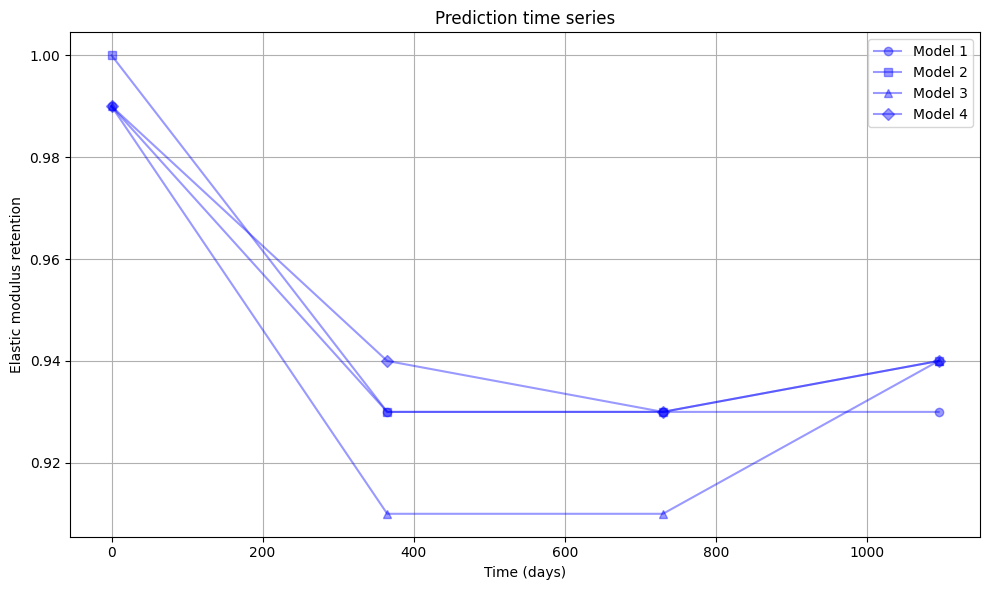

In [375]:
# Test: evaluate prediction time series using cooling tower data

file_name = 'prediction-dataset.csv'
log_transf = []
unaged_modulus = 24.0

# Definition of dataset path
file_path=str(os.getcwd()) + '\\' + file_name

# Read .CSV as pandas dataframe
df = pd.read_csv(file_path, delimiter=';')

# Drop columns that are not important for the analysis
df = df.drop(columns=cols_to_drop)

# Remove unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Filter target property values that appear less than min_target_count times
value_counts = df[predictor.target].value_counts()
valid_values = value_counts[value_counts > 0].index
df = df[df[predictor.target].isin(valid_values)]

# Log-transform features with outlier values
for i in range(len(log_transf)):
    df[log_transf[i]] = np.log10(df[log_transf[i]])

# Separate independent variables from target
X_pred = df.drop(columns=predictor.target)

y_preds = []
for i in range(len(predictor.trained_models)):
    y_pred = predictor.trained_models[i]['model'].predict(X_pred).tolist()
    for j in range(len(y_pred)):
        # y_pred[j] = round(y_pred[j]/unaged_modulus, 2)
        y_pred[j] = round(y_pred[j], 2)
    y_preds.append(y_pred)

for i in range(len(y_preds)):
    print(y_preds[i])

# Plot prediction time series
t = [0, 365, 730, 1095]
# t = [0, 365, 730, 1095, 1825, 3650, 7300]
# t = np.log10([1, 50, 75, 100, 150, 200, 250, 300, 365, 450, 550, 650, 730, 1825, 3650, 5475, 9125, 14600, 18250])

markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', 'd']

plt.figure(figsize=(10, 6))
for i in range(len(predictor.trained_models)):
    marker = markers[i]  # Change marker every 2 models
    plt.plot(
        t,
        y_preds[i],
        marker=marker,
        color='blue',
        linestyle='-',
        alpha=0.4,
        label=f'Model {i+1}'
        )
    
# Plot formatting
plt.xlabel("Time (days)")
plt.ylabel("Elastic modulus retention")
# plt.ylim(0, )  # Adjust based on your scores
plt.title('Prediction time series')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

y_pred = 1.00, y_holdout = 1.0
Abs. error: -0.00, rel. error: -0.10%

y_pred = 0.96, y_holdout = 0.875
Abs. error: 0.04, rel. error: 5.01%

y_pred = 0.97, y_holdout = 0.895
Abs. error: 0.02, rel. error: 2.66%

y_pred = 0.95, y_holdout = 0.861
Abs. error: 0.04, rel. error: 4.19%

y_pred = 0.95, y_holdout = 0.884
Abs. error: 0.01, rel. error: 1.47%

y_pred = 0.95, y_holdout = 0.878
Abs. error: 0.02, rel. error: 1.80%

y_pred = 0.95, y_holdout = 0.925
Abs. error: -0.03, rel. error: -3.37%

y_pred = 1.00, y_holdout = 1.0
Abs. error: 0.00, rel. error: 0.00%

y_pred = 0.96, y_holdout = 0.875
Abs. error: 0.09, rel. error: 10.20%

y_pred = 0.97, y_holdout = 0.895
Abs. error: 0.07, rel. error: 8.08%

y_pred = 0.95, y_holdout = 0.861
Abs. error: 0.09, rel. error: 10.33%

y_pred = 0.95, y_holdout = 0.884
Abs. error: 0.07, rel. error: 7.81%

y_pred = 0.95, y_holdout = 0.878
Abs. error: 0.07, rel. error: 7.79%

y_pred = 0.95, y_holdout = 0.925
Abs. error: 0.02, rel. error: 2.58%

y_pred = 1.00, y_h

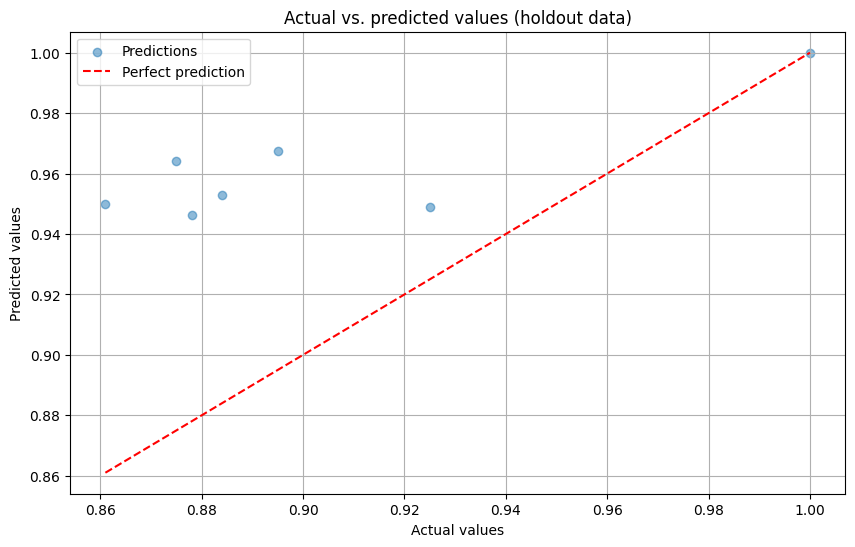

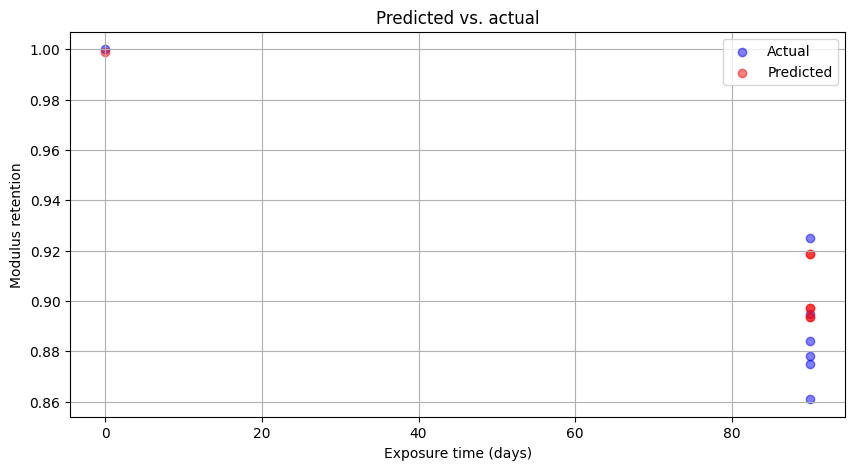

In [376]:
predictor.holdout_test(file_name='holdout-dataset.csv', cols_to_drop=cols_to_drop,
    model_i=1, log_transf=[])

Train MAE: 0.718 ± 0.005
Valid MAE: 0.582 ± 0.015


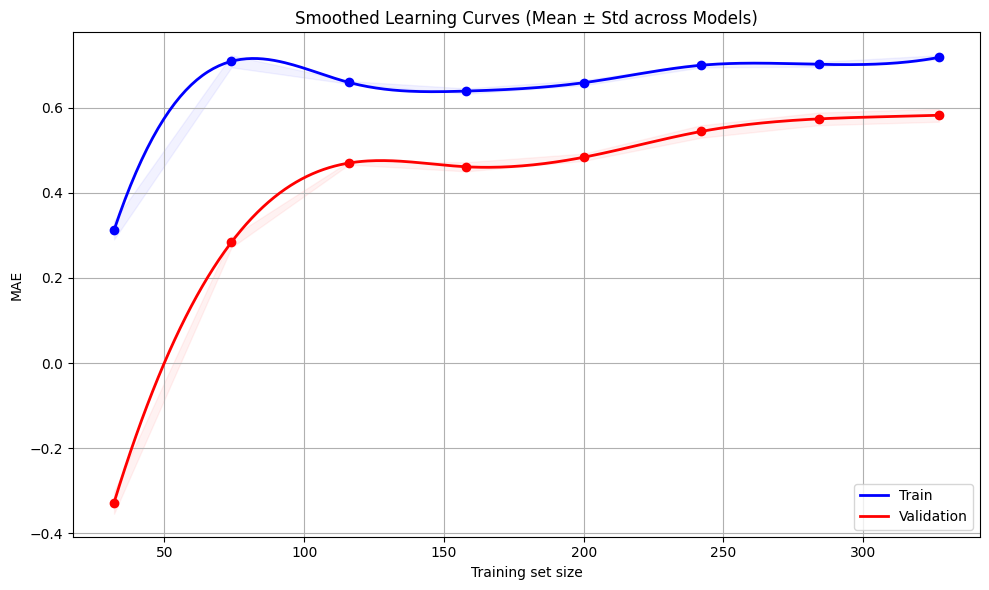

In [377]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Separate independent variables from target
X = predictor.dataset['X']
y = predictor.dataset['y']

plt.figure(figsize=(10, 6))

train_curve_all = []
valid_curve_all = []

for i in range(len(predictor.trained_models)):
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        predictor.trained_models[i]['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 8),
        cv=predictor.cv_strategy, scoring='r2', return_times=True
    )

    # Store the mean across CV folds
    train_curve_all.append(train_scores.mean(axis=1))
    valid_curve_all.append(test_scores.mean(axis=1))

# Convert to numpy arrays for vectorized operations
train_curve_all = np.array(train_curve_all)
valid_curve_all = np.array(valid_curve_all)

# Calculate mean and std across all models
train_mean = train_curve_all.mean(axis=0)
train_std = train_curve_all.std(axis=0)
valid_mean = valid_curve_all.mean(axis=0)
valid_std = valid_curve_all.std(axis=0)

# Smooth the average curves with spline interpolation
x_smooth = np.linspace(train_sizes.min(), train_sizes.max(), 300)
train_spline = make_interp_spline(train_sizes, train_mean)(x_smooth)
valid_spline = make_interp_spline(train_sizes, valid_mean)(x_smooth)

# Plot average smoothed curves
plt.plot(x_smooth, train_spline, color='blue', label='Train', linewidth=2)
plt.plot(x_smooth, valid_spline, color='red', label='Validation', linewidth=2)

# Fill between ±std (uncertainty cloud)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.05, color='blue')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.05, color='red')

# Plot original mean values with circle markers
plt.plot(train_sizes, train_mean, 'o', color='blue')
plt.plot(train_sizes, valid_mean, 'o', color='red')

# Print average scores
print(f"Train MAE: {train_mean[-1]:.3f} ± {train_std[-1]:.3f}")
print(f"Valid MAE: {valid_mean[-1]:.3f} ± {valid_std[-1]:.3f}")

# Final plot touches
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.title("Smoothed Learning Curves (Mean ± Std across Models)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Train MAE: 0.036 ± 0.001
Valid MAE: 0.043 ± 0.004


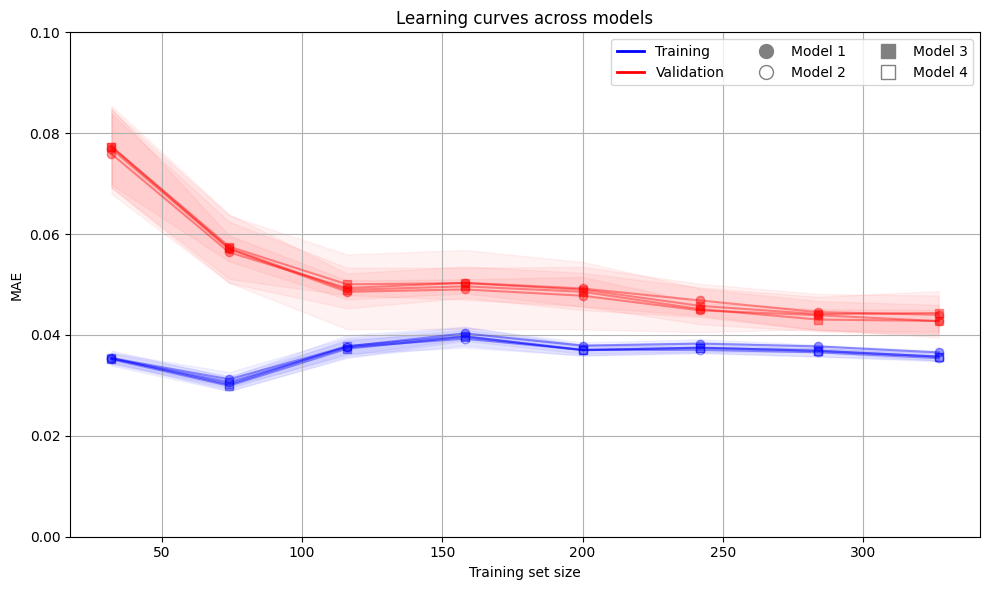

Train RMSE: 0.036 ± 0.001
Valid RMSE: 0.044 ± 0.005


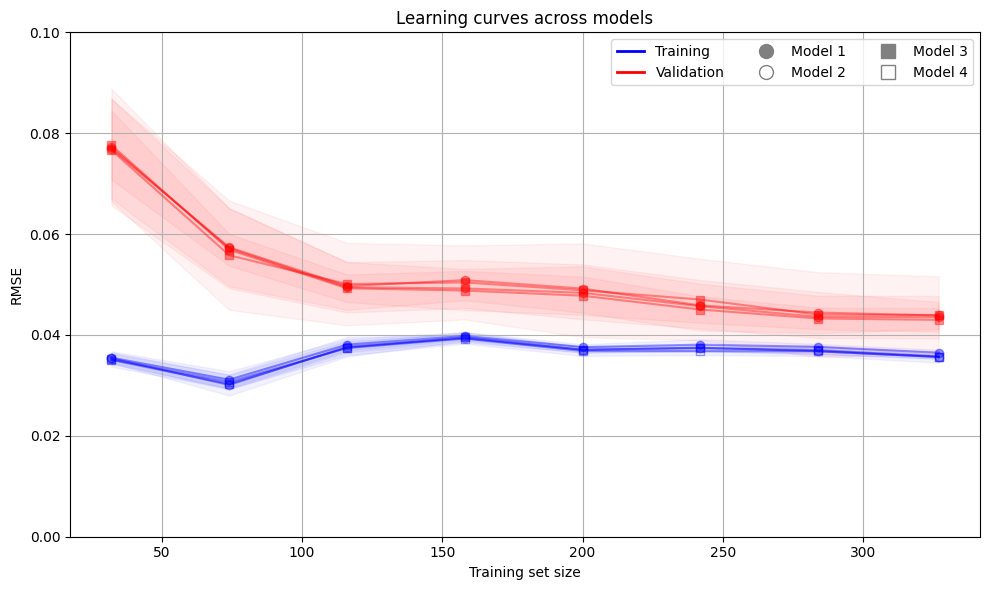

Train R²: 0.72 ± 0.01
Valid R²: 0.57 ± 0.05


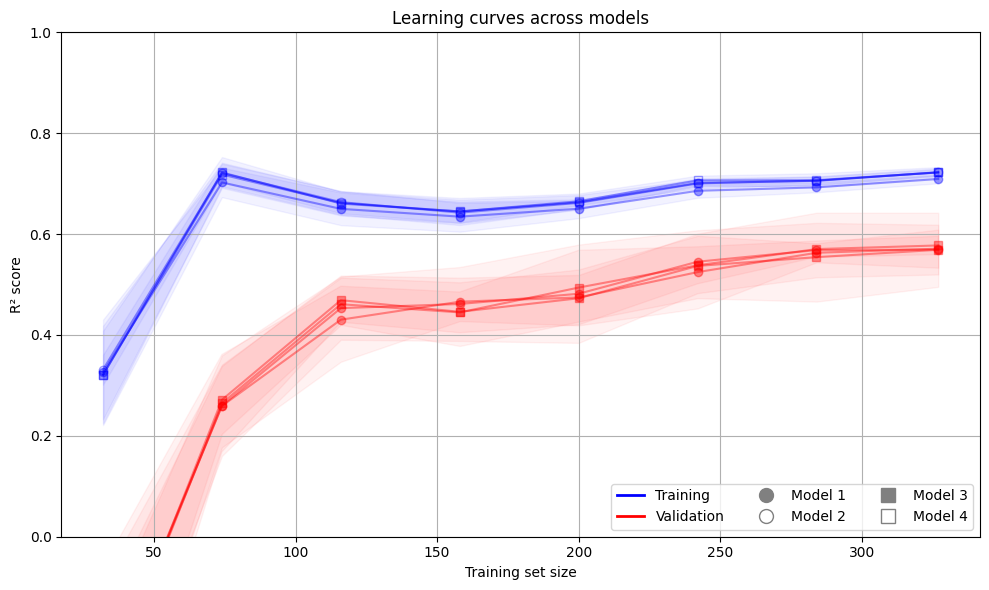

In [ ]:
predictor.plot_learning_curves(metrics=[1,1,1], ylim_1=(0, .1), ylim_2=(0, 0.1), ylim_3=(-.4, 1))


Target boxplot distribution


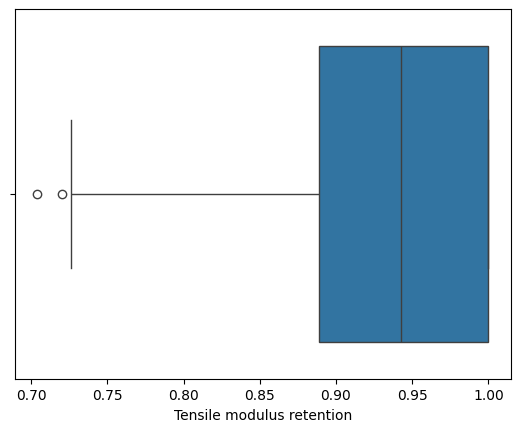


Overall feature distribution


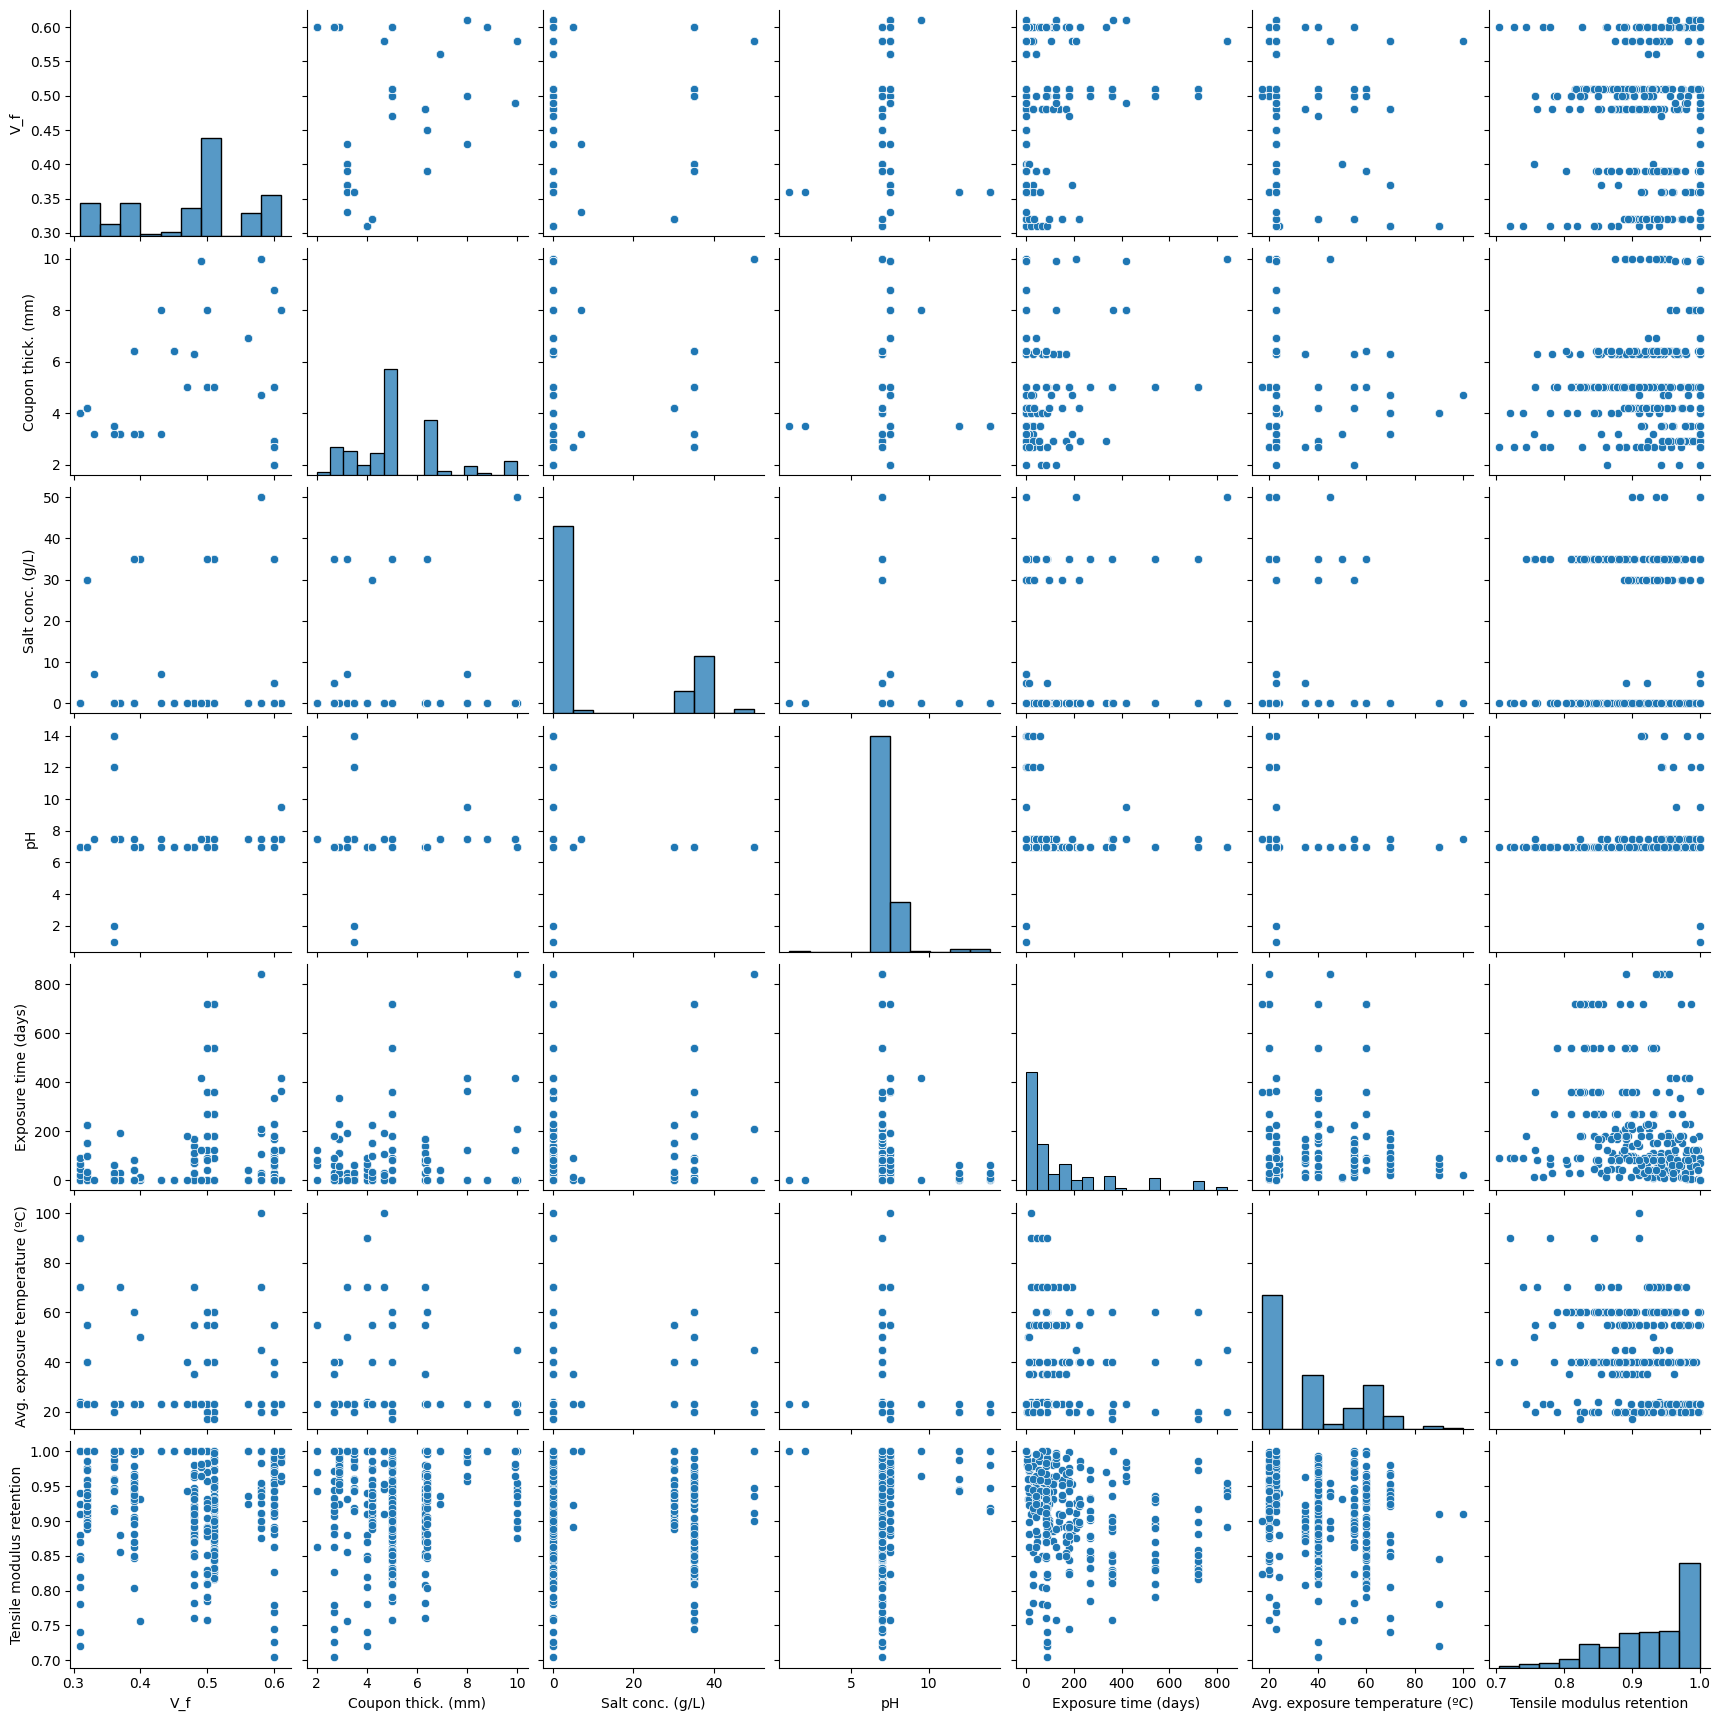


Most important feature vs. target


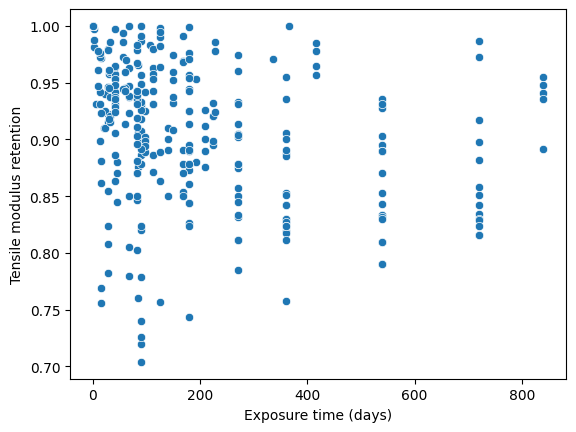

In [379]:
predictor.plot_feature_distribution(main_feature='Exposure time (days)')

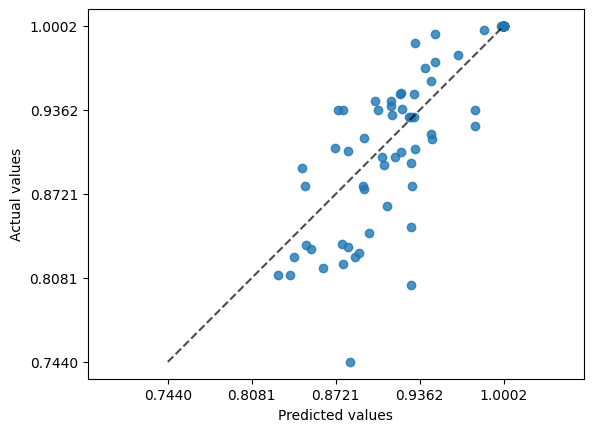

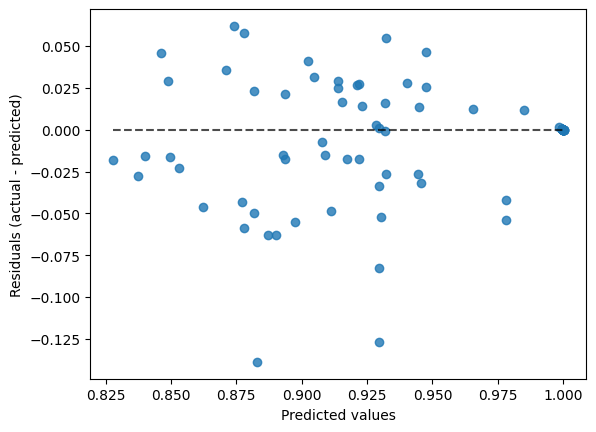

In [380]:
predictor.plot_pred_error()


Model 1


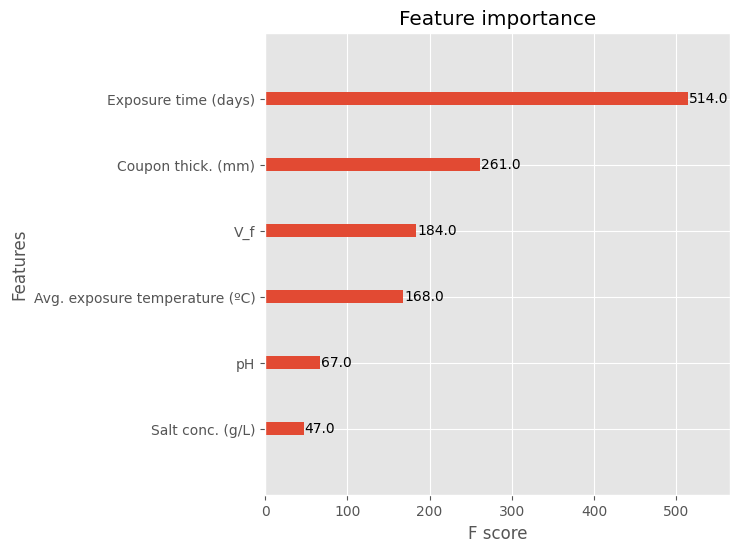


Model 2


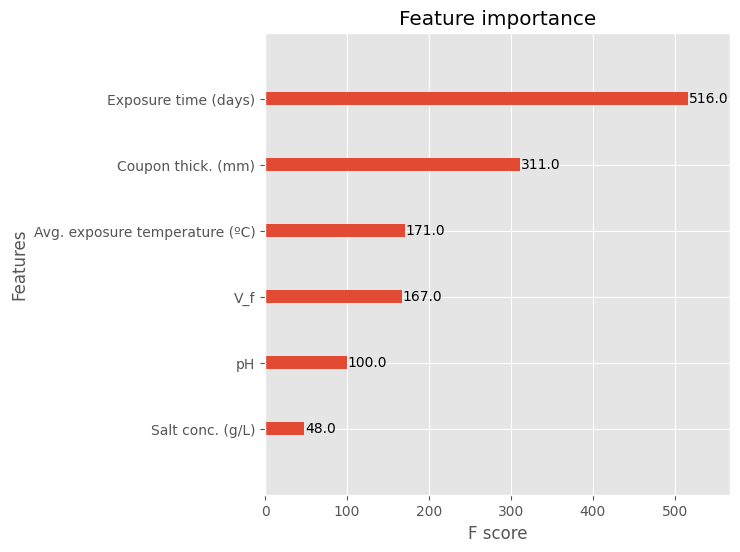


Model 3


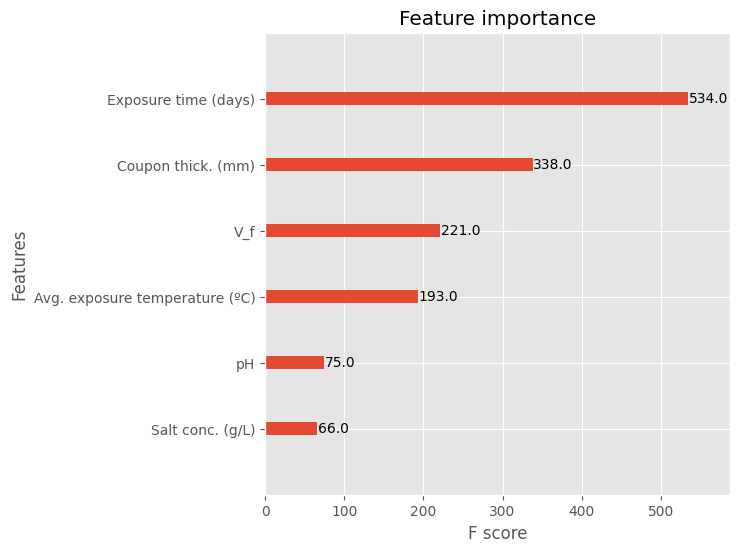


Model 4


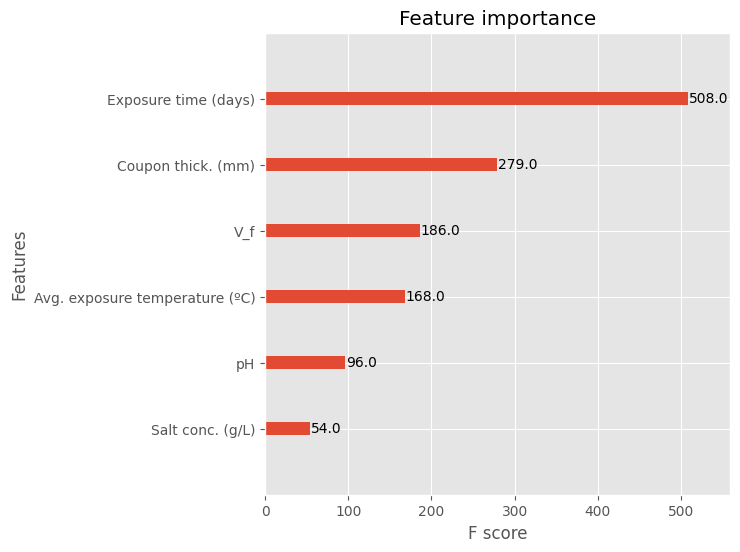

In [381]:
predictor.plot_importance()

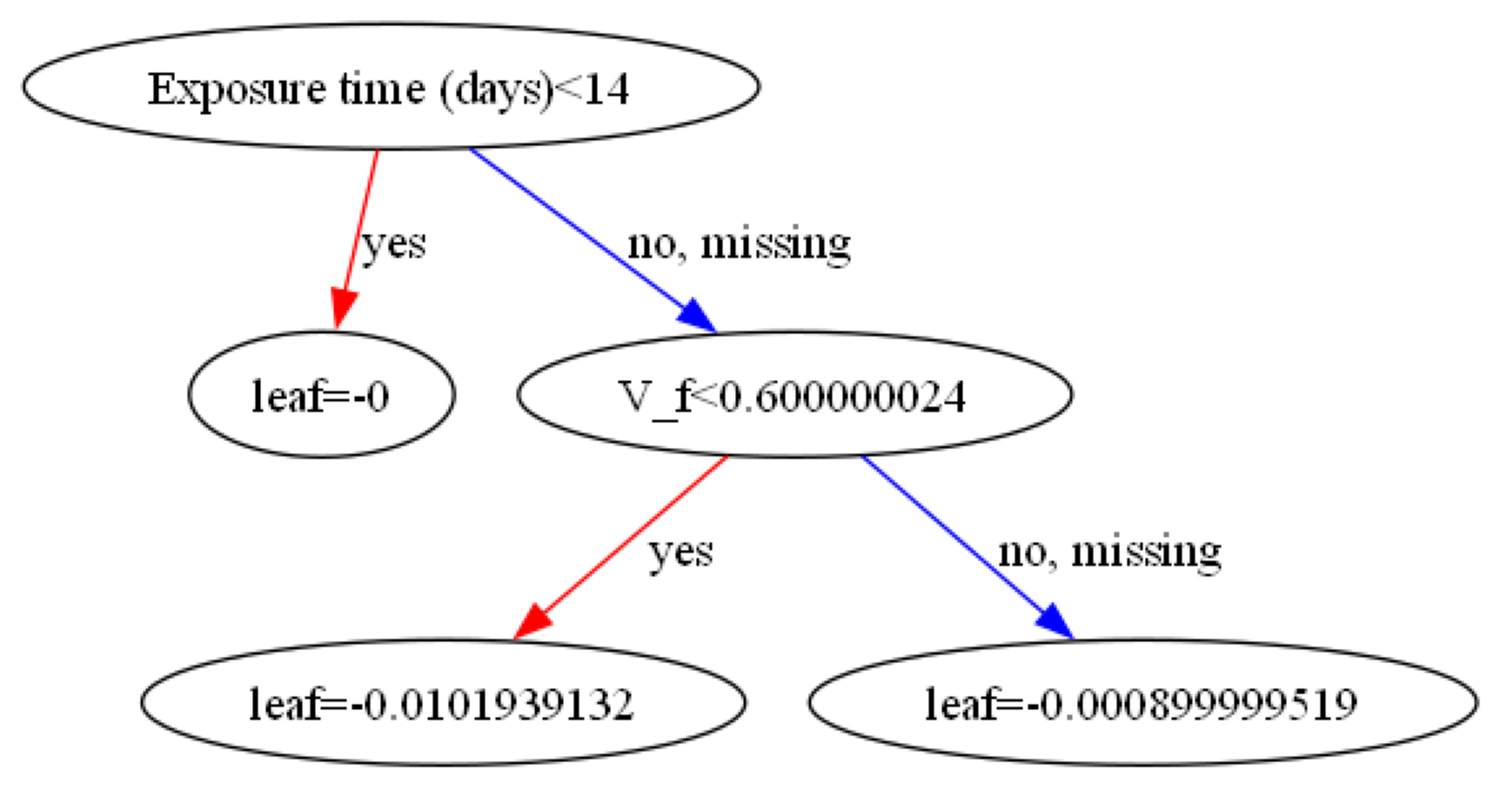

In [382]:
predictor.plot_tree()

In [383]:
from sklearn.model_selection import cross_val_score, KFold

df = load_dataset(target='Tensile modulus retention', cols_to_drop=cols_to_drop)
X = df.drop(columns=predictor.target)
y = df[predictor.target]

# Outer CV: Evaluate performance
for i in range(len(predictor.trained_models)):
    outer_scores = cross_val_score(
        predictor.trained_models[i]['model'], X, y, 
        cv=KFold(5, shuffle=True), 
        scoring='r2'
    )
    print(f"Unbiased R²: {np.mean(outer_scores):.3f} ± {np.std(outer_scores):.3f}")

Unbiased R²: 0.573 ± 0.070
Unbiased R²: 0.585 ± 0.056
Unbiased R²: 0.588 ± 0.024
Unbiased R²: 0.583 ± 0.056


In [384]:
predictor.lin_correl()

pH                                0.094374
Coupon thick. (mm)                0.089457
V_f                               0.014382
Salt conc. (g/L)                 -0.123585
Avg. exposure temperature (ºC)   -0.439671
Exposure time (days)             -0.458058
dtype: float64


95% prediction interval: ±0.07


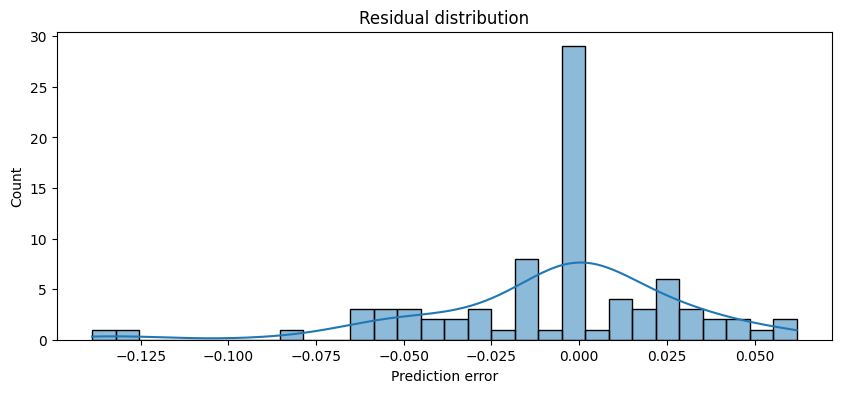

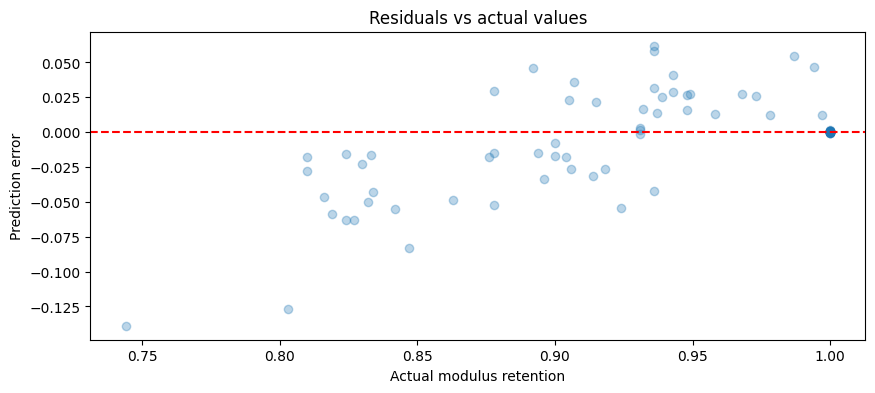

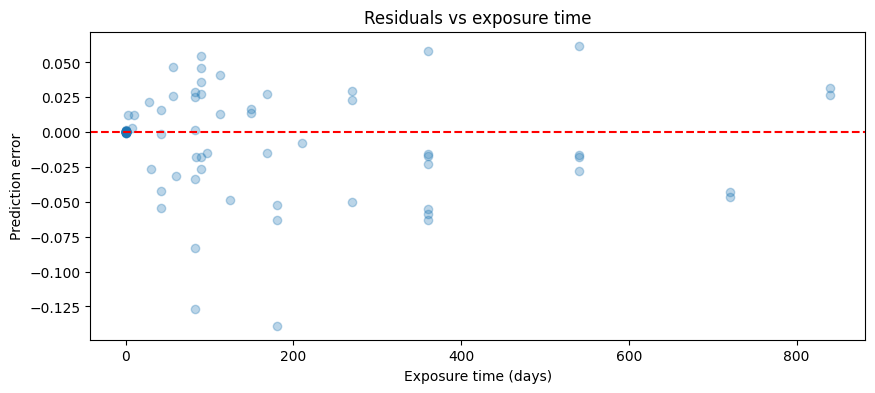

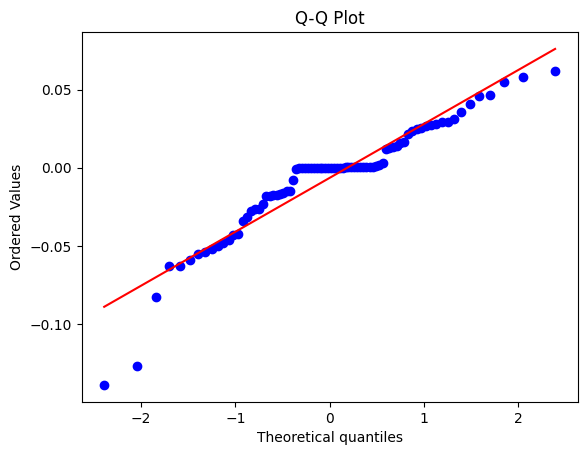

In [385]:
predictor.residual_analysis(model_i=0, feature='Exposure time (days)')

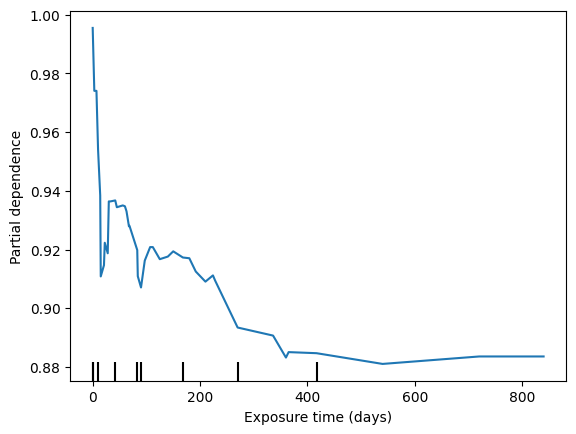

In [386]:
predictor.pdp(model_i=0, feature='Exposure time (days)')

In [387]:
# Fim do processamento
now = datetime.now()

print(now.strftime("%d/%m/%Y %H:%M:%S"))
print("\nProcessing time: %s seconds\n" % (round((time.time() - start_time), 2)))

15/04/2025 11:05:21

Processing time: 489.55 seconds

